In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from time import time
import gc
from scipy.stats import linregress

from qiskit.quantum_info import Statevector, Pauli
from qtealeaves.observables import TNObservables, TNObsLocal

from tfim import TFIMChain
from datastream import load_results, save_results
from debugger import message_checkpoints

import warnings
warnings.filterwarnings("ignore")

In [2]:
# ===========================================================
# GLOBAL PLOT STYLE 
# Note: Requires a working LaTeX installation on your system
# ===========================================================

plt.rcParams.update({
    # LaTeX and Fonts
    "text.usetex": True,
    "font.family": "cmr10",
    "text.latex.preamble": r"\usepackage{amsmath, amssymb}",
    "font.size": 20,         
    "axes.titlesize": 20,      
    "axes.labelsize": 20,      
    "legend.fontsize": 20,    
    "xtick.labelsize": 20,
    "ytick.labelsize": 20,

    # Line widths
    "axes.linewidth": 1.2,     
    "lines.linewidth": 1.5,    
    "lines.markersize": 8,    

    # Ticks
    "xtick.direction": "in",
    "ytick.direction": "in",
    "xtick.top": True,
    "ytick.right": True,
    "xtick.major.width": 1.2,
    "ytick.major.width": 1.2,

    # Grid
    # "axes.grid": True,
    # "grid.linestyle": "dashed",
    # "grid.alpha": 0.2,

    # Legend
    "legend.frameon": False,
    "legend.loc": "best"
    })

## Quantum circuit simulation

In the external library "tfim" an object representing the Transverse Field Ising Model has been implemented. It contains all the methods needed to create and simulate a quantum circuit with the help of $\texttt{Qiskit}$ and $\texttt{QMatchaTea}$ libraries. 

First of all, let's visualize the first Trotter step of the Ising time evolution for three qubits.

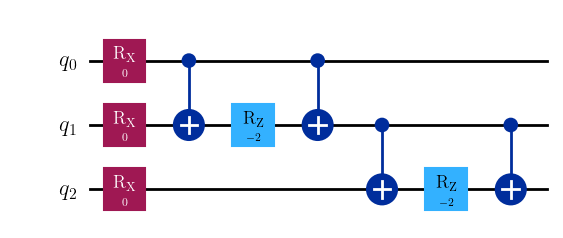

In [3]:
test_chain = TFIMChain(n_qubits=3, T=1, n_steps=1)
test_chain.draw_circuit()

## Benchmarking Bond Dimension and Complexity

The **Matrix Product State (MPS)** ansatz reduces the exponential cost of simulating many-body systems by approximating the full wavefunction. Through the iterative application of SVD, the state is compressed by discarding the components with negligible weight (low singular values).

The computational cost of the simulation is dominated by the bond dimension $m$.
Here, we compare the performance of the MPS approach against exact state vector simulation, focusing on the maximum simulateable system size and the trade-off between accuracy, execution time, and memory usage.

In [4]:
# Controls
BOND_FILENAME = "datafiles/energy_convergence_data.pkl" 
T = 40.
n_steps = 400
g_vals = [0.5, 1.0, 2.0]

# Parameters to test
bond_dim_ferro = [8, 16, 32, 64, 128, 256] 
n_qubits_ferro = [10, 20, 40, 100] 

bond_dim_crit = [8, 16, 32, 64, 128, 256] 
n_qubits_crit = [10, 20, 40] 

bond_dim_para = [8, 16, 32, 64, 128, 256, 512] 
n_qubits_para = [10, 20, 40]

In [5]:
# Benchmark execution
results_db = load_results(BOND_FILENAME)
if results_db is None: results_db = {}

message_checkpoints(0, f"Beginning Energy benchmark (File: {BOND_FILENAME})\n", True)

for g in g_vals:
    # Select parameters
    if g == 0.5:
        target_bonds = bond_dim_ferro
        target_n_qubits = n_qubits_ferro
    elif g == 1.0:
        target_bonds = bond_dim_crit
        target_n_qubits = n_qubits_crit
    elif g == 2.0:
        target_bonds = bond_dim_para
        target_n_qubits = n_qubits_para
    else:
        raise ValueError("ERROR: g must be 0.5, 1 or 2.") 

    # Look whether a certain value of g exists or not in the dictionary
    if g not in results_db:
        results_db[g] = {}

    for nq in target_n_qubits:

        # Check for already existent data
        existing_data = results_db[g].get(nq, [])
        
        # Skip if the data length matches
        if len(existing_data) >= len(target_bonds):
            print(f"Skipping g={g}, N={nq} (Found {len(existing_data)} entries)")
            continue
        
        message_checkpoints(0, f"\n=================================================", True)
        message_checkpoints(0, f"Running g={g}, N={nq} (Bond dims: {target_bonds})", True)
        message_checkpoints(0, f"=================================================", True)
        
        # Create the Ising chain object for a given number of qubits
        chain = TFIMChain(n_qubits=nq, T=T, n_steps=n_steps)

        # Benchmark execution
        try:
            metrics = chain.benchmark_bond_dimensions(g=g, m_list=target_bonds)

            # Store data in the dictionary
            results_db[g][nq] = metrics
            
            # Save data on file
            save_results(results_db, BOND_FILENAME)
            
        except Exception as e:
            raise TypeError(f"CRITICAL ERROR for g={g}, N={nq}: {e}")

message_checkpoints(0, "\nUpdate completed.", True)

Data correctly loaded from 'datafiles/energy_convergence_data.pkl'


Beginning Energy benchmark (File: datafiles/energy_convergence_data.pkl)

Skipping g=0.5, N=10 (Found 6 entries)
Skipping g=0.5, N=20 (Found 6 entries)
Skipping g=0.5, N=40 (Found 6 entries)
Skipping g=0.5, N=100 (Found 6 entries)
Skipping g=1.0, N=10 (Found 6 entries)
Skipping g=1.0, N=20 (Found 6 entries)
Skipping g=1.0, N=40 (Found 6 entries)
Skipping g=2.0, N=10 (Found 7 entries)
Skipping g=2.0, N=20 (Found 7 entries)
Skipping g=2.0, N=40 (Found 7 entries)

Update completed.


Data correctly loaded from 'datafiles/energy_convergence_data.pkl'




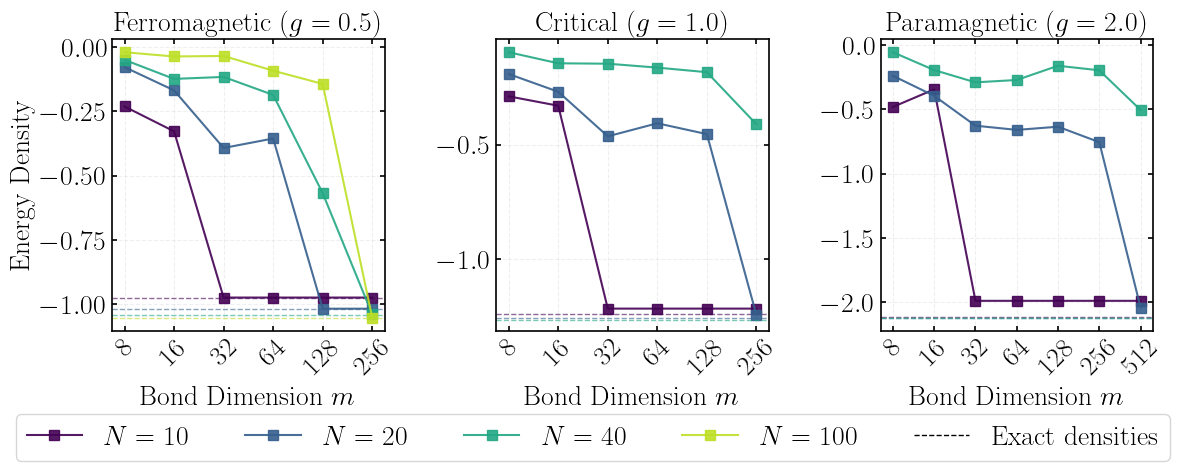

In [6]:
def get_exact_energy_density(N, g):
    """
    Compute the exact energy density

    Args:
        N (int): number of qubits
        g (float): transverse field strength

    Returns:
        float: ground state energy density
    """
    M = np.zeros((N, N))
    np.fill_diagonal(M, g)
    np.fill_diagonal(M[:, 1:], 1.0)
    
    # Compute total energy as the sum of singular values
    E_total = -np.sum(np.linalg.svd(M, compute_uv=False))
    return E_total/N

g_vals = [0.5, 1.0, 2.0]
titles = ["Ferromagnetic ($g=0.5$)", "Critical ($g=1.0$)", "Paramagnetic ($g=2.0$)"]

# Mappiamo le liste di bond dimensions per ogni g (assumendo che le variabili esistano)
bond_map = {
    0.5: bond_dim_ferro,
    1.0: bond_dim_crit,
    2.0: bond_dim_para
}

# Load data from file
bond_data = load_results(BOND_FILENAME)

# Cosmetics
all_N = sorted(list({k for g in bond_data for k in bond_data[g].keys()}))
colors = plt.cm.viridis(np.linspace(0, 0.9, len(all_N)))
color_map = dict(zip(all_N, colors))

# Plot
fig, axes = plt.subplots(1, 3, figsize=(12, 4.5), sharey=False)

for ax, g, title in zip(axes, g_vals, titles):
    if g not in bond_data: continue

    # Iterate on each N
    for N in sorted(bond_data[g].keys()):
        # Extract data
        entry = bond_data[g][N]
        raw_vals = [x["energy"] for x in entry] if isinstance(entry, list) else entry
        
        y_density = np.array(raw_vals[:len(bond_map[g])]) / N
        x_axis = bond_map[g][:len(y_density)]
                
        # Plot MPS energy density
        ax.plot(x_axis, y_density, "s-", color=color_map[N], markersize=7, label=f"$N={N}$", alpha=0.9)
        
        # Plot Exact energy density
        exact_val = get_exact_energy_density(N, g)
        ax.axhline(exact_val, color=color_map[N], linestyle="dashed", linewidth=1, alpha=0.6)

    ax.set_title(title)
    ax.set_xlabel("Bond Dimension $m$")
    ax.set_xscale("log", base=2)
    ax.set_xticks(bond_map[g])
    ax.set_xticklabels(bond_map[g], rotation=45)
    ax.grid(linestyle="dashed", alpha=0.2)
    
    if g == 0.5:
        ax.set_ylabel("Energy Density")

# Shared legend
handles, labels = axes[0].get_legend_handles_labels()

exact_line = mlines.Line2D([], [], color="black", linestyle="--", linewidth=1,  label="Exact densities")
handles.append(exact_line)
labels.append("Exact densities")

fig.legend(handles, labels, loc="lower center", bbox_to_anchor=(0.5, -0.1), ncol=len(labels), frameon=True)

plt.tight_layout()
plt.subplots_adjust(bottom=0.22)
plt.savefig("plots/energy_convergence.pdf", bbox_inches='tight')
plt.show()

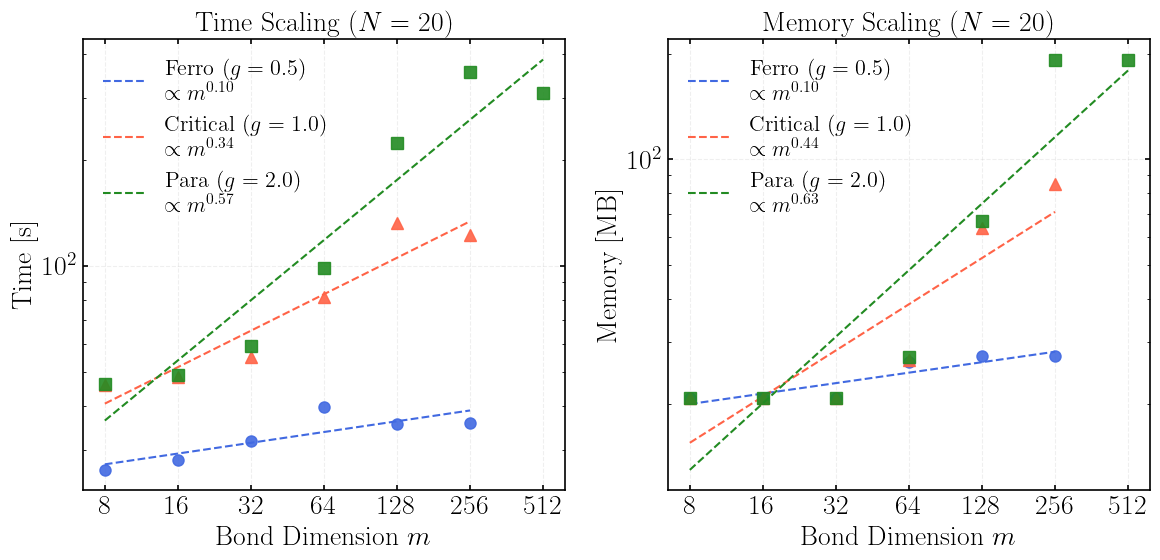

In [7]:
# Configuration
TARGET_N = 20  
phases = {
    0.5: {"name": "Ferro ($g=0.5$)",    "color": "royalblue",   "marker": "o"},
    1.0: {"name": "Critical ($g=1.0$)", "color": "tomato",      "marker": "^"},
    2.0: {"name": "Para ($g=2.0$)",     "color": "forestgreen", "marker": "s"}
}

# Plot
fig, (ax_time, ax_mem) = plt.subplots(1, 2, figsize=(12, 6))

for g, style in phases.items():
    if g not in bond_data or TARGET_N not in bond_data[g]: continue
    
    entry = bond_data[g][TARGET_N]

    # Extract data
    if isinstance(entry, list):
        m_list = [x["bond_dim"] for x in entry]
        t_list = [x.get("time", x.get("time_s")) for x in entry]     
        mem_list = [x.get("memory", x.get("memory_mb")) for x in entry] 
    else:
        m_list = entry.get("bond_dim", [])
        t_list = entry.get("time", entry.get("time_s", []))
        mem_list = entry.get("memory", entry.get("memory_mb", []))

    sorted_data = sorted(zip(m_list, t_list, mem_list))
    m, t, mem = np.array(sorted_data).T 

    ## TIME
    ax_time.plot(m, t, marker=style["marker"], color=style["color"], ls="", alpha=0.9)
    slope, intercept, _, _, _ = linregress(np.log(m), np.log(t))
    
    label_t = f"{style['name']}\n$\\propto m^{{{slope:.2f}}}$"
    ax_time.plot(m, np.exp(intercept) * m**slope, ls='--', color=style["color"], label=label_t)

    ## MEMORY
    ax_mem.plot(m, mem, marker=style["marker"], color=style["color"], ls="", alpha=0.9)
    slope_m, intercept_m, _, _, _ = linregress(np.log(m), np.log(mem))
    
    label_m = f"{style['name']}\n$\\propto m^{{{slope_m:.2f}}}$"
    ax_mem.plot(m, np.exp(intercept_m) * m**slope_m, ls='--', color=style["color"], label=label_m)

# Final formatting
for ax in [ax_time, ax_mem]:
    ax.set_xscale("log", base=2)
    ax.set_yscale("log")
    ax.set_xlabel("Bond Dimension $m$")
    ax.set_xticks(m) 
    ax.set_xticklabels([int(val) for val in m])
    ax.grid(True, which="major", linestyle="dashed", alpha=0.2)
    ax.legend(fontsize=16, frameon=False)

ax_time.set_title(f"Time Scaling ($N={TARGET_N}$)")
ax_time.set_ylabel("Time [s]")
ax_mem.set_title(f"Memory Scaling ($N={TARGET_N}$)")
ax_mem.set_ylabel("Memory [MB]")

plt.tight_layout()
plt.savefig("plots/scaling_analysis.pdf")
plt.show()

### MPS validation

In [ ]:
# File variables
MAX_N_FILENAME = "datafiles/max_n_qubits_benchmark.pkl"
FORCE_RECOMPUTE_MAX_N = False

loaded_val = load_results(MAX_N_FILENAME)

if loaded_val is None or FORCE_RECOMPUTE_MAX_N:
    # Check for the biggest N we can simulate
    message_checkpoints(0, "Searching for the biggest N for state vector (RAM check)...\n", True)

    optimal_n_qubits = 0
    g_bench = 1.0 

    for nq in range(2, 32, 2):
        message_checkpoints(0, f"Testing {nq} qubits...", True)

        try:
            # Create the Ising chain object
            chain = TFIMChain(n_qubits=nq, T=T, n_steps=n_steps)
            
            # Generate the circuit
            qc = chain.circuit_hamiltonian(g=g_bench)

            # Generate the state vector
            start = time()
            sv = Statevector(qc)
            stop = time()

            elapsed = stop - start
            print(f"OK ({elapsed:.2f}s)")

            # Store the max number of qubits so far
            optimal_n_qubits = nq

            # Break if it takes more than 3 minutes
            if (elapsed > 180): 
                print("Time limit reached.")
                break

            # Memory cleanup
            del sv
            del qc
            del chain
            gc.collect()
        
        except MemoryError:
            print("\nERROR: insufficient memory!")
            optimal_n_qubits = max(0, nq-2)
            break
        
        except Exception as e:
            print(f"\nUnexpected error: {e}")
            optimal_n_qubits = max(0, nq-2)
            break
    
    # Save results into a file
    save_results(optimal_n_qubits, MAX_N_FILENAME)

else:
    message_checkpoints(0, "Using loaded optimal_n_qubits from file.", True)
    optimal_n_qubits = loaded_val

message_checkpoints(0, f"\nThe max number of qubits we can simulate is: {optimal_n_qubits}", True)

Data correctly loaded from 'datafiles/max_n_qubits_benchmark.pkl'


Using loaded optimal_n_qubits from file.

The max number of qubits we can simulate is: 22


## GS energy and average magnetization

Having assessed that the maximum size of the Hilbert space I can reach with both methods is 20, and considering the computational cost required to simulate heavy systems, from now on we set the number of qubits to 20 and bond dimension to 256. 

### Energy

We would like to compare the energy of the ground state computed with the built in methods of the $\texttt{QTeaLeaves}$ and with exact diagonalization:

$$E(t) = \langle H(t) \rangle = -g(t) \sum_i \langle \sigma^x_i \rangle_t - \sum_i \langle \sigma^z_i \sigma^z_{i+1} \rangle_t$$

In [10]:
# Control parameters
g_vals = [0.5, 1.0, 2.0]
n_qubits = 20
m = 256
stride = 20

# Params to get dt=0.05
T = 40.
n_steps = 1600

# Create the Ising chain object
ising_chain = TFIMChain(n_qubits=n_qubits, T=T, n_steps=n_steps)

In [11]:
# Dictionaries to store the results
exact_energies = {}
simulated_energies = {}
times = {}

# File saving management
ENERGY_FILENAME = "datafiles/GS_energy_results.pickle"
FORCE_RECOMPUTE = False # Set to True if you want to force recomputation

# Try to load data from the file if it exists
energy_data = load_results(ENERGY_FILENAME)

if energy_data is None or FORCE_RECOMPUTE:
    message_checkpoints(0, "Computing energy data...", True)
    
    # Compute exact and simulated energies
    for g in g_vals:
        print(f"\n======================")
        print(f"GS evolution for g={g}")
        print(f"======================")
        
        # Compute times and energies
        t_exact, E_exact = ising_chain.exact_GS_energy(g, stride=stride)
        t_sim, E_sim = ising_chain.MPS_GS_energy(g, m, stride=stride)

        # Store the results in the dictionaries
        exact_energies[g] = E_exact
        simulated_energies[g] = E_sim
        times[g] = t_sim 
    
    # Prepare the data package to be saved
    data_to_save = {
        "exact_energies": exact_energies,
        "simulated_energies": simulated_energies,
        "times": times
    }
    
    # Save the results to the file
    save_results(data_to_save, ENERGY_FILENAME)
    message_checkpoints(0, "\nData correctly saved!", True)

else:
    # If the file exists, unpack the loaded data
    message_checkpoints(0, f"Using loaded data from '{ENERGY_FILENAME}'.", True)
    exact_energies = energy_data["exact_energies"]
    simulated_energies = energy_data["simulated_energies"]
    times = energy_data["times"]

Data correctly loaded from 'datafiles/GS_energy_results.pickle'


Using loaded data from 'datafiles/GS_energy_results.pickle'.


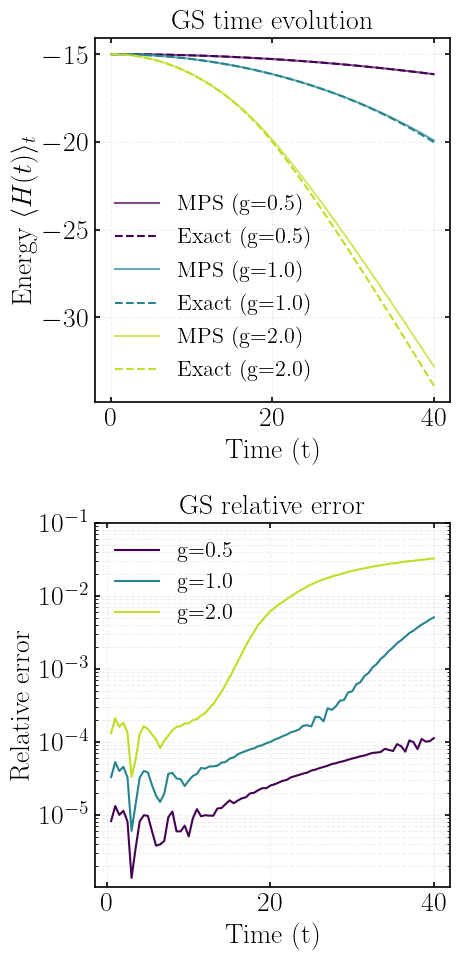

In [ ]:
# Plot energy results
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(5, 10))

colors = plt.cm.viridis(np.linspace(0, 0.9, len(g_vals)))

for i, g in enumerate(g_vals):
    ax1.plot(times[g], simulated_energies[g], color=colors[i], linestyle="solid", alpha=0.7, label=f"MPS (g={g})")
    ax1.plot(times[g], exact_energies[g], color=colors[i], linestyle="dashed", linewidth=1.5, label=f"Exact (g={g})")
    
ax1.set_title("GS time evolution")
ax1.set_xlabel("Time (t)")
ax1.set_ylabel(r"Energy $\langle H(t) \rangle_t$")
ax1.grid(True, alpha=0.2)

ax1.legend(frameon=False, loc="best", fontsize=16)

# Relative errors
for i, g in enumerate(g_vals):
    # Compute the relative error
    epsilon = np.abs((np.array(simulated_energies[g]) - np.array(exact_energies[g]))/np.array(exact_energies[g]))
    ax2.plot(times[g][1:], epsilon[1:], color=colors[i], label=f"g={g}")
    ax2.axhline(0, color="black", linestyle="dotted", linewidth=1)

ax2.set_yscale("log")
ax2.set_ylim(1.01e-6, 1.01e-1)
ax2.set_title("GS relative error")
ax2.set_xlabel("Time (t)")
ax2.set_ylabel(r"Relative error")
ax2.grid(True, alpha=0.2)

ax2.legend(frameon=False, loc="best", fontsize=16)

list_of_spines = ["left", "right", "top", "bottom"]
for ax in [ax1, ax2]:
    ax.tick_params(direction="in")
    ax.grid(True, which="both", linestyle="dashed", alpha=0.2)
    
    for sp in list_of_spines:
        ax.spines[sp].set_linewidth(1.2)

plt.tight_layout()
plt.savefig("plots/energy.pdf")
plt.show()

### Average magnetization $M_z = \frac{1}{N} \sum_i |\langle \sigma_i^z \rangle|$

In [13]:
# File variables
PT_FILENAME = "datafiles/phase_transition_results.pkl"
FORCE_RECOMPUTE = False

# Load data from file or compute them
phase_transition_dict = load_results(PT_FILENAME)

if phase_transition_dict is None or FORCE_RECOMPUTE:
    message_checkpoints(0, "Computing phase transition data...\n", True)

    # Compute the phase transition
    phase_transition_dict = ising_chain.compute_phase_transition_data(g_max=3, bond_dim=m, stride=stride)

    # Save the results into file
    save_results(phase_transition_dict, PT_FILENAME)

else:
    message_checkpoints(0, "Using loaded phase transition data.", True)
    
# Extract data for easier usage
g_axis = phase_transition_dict["g_axis"]
mps_op = phase_transition_dict["mps_order_param"]
exact_op = phase_transition_dict["exact_order_param"]
heatmap_matrix = np.array(phase_transition_dict["heatmap_data"]).T

Data correctly loaded from 'datafiles/phase_transition_results.pkl'


Using loaded phase transition data.


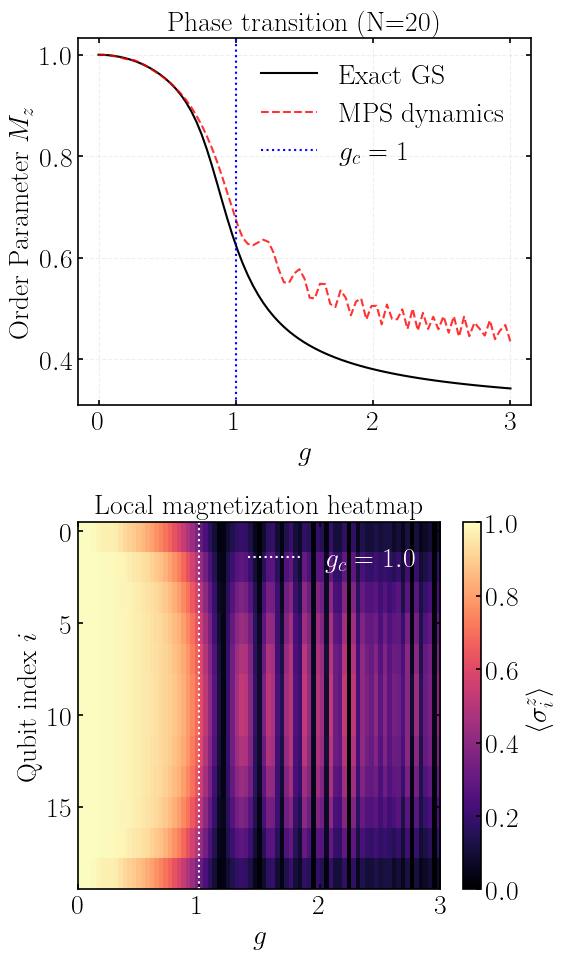

In [14]:
# Plot the phase transition
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 10))

# Order Parameter
ax1.plot(g_axis, exact_op, linestyle="solid", color="black", linewidth=1.5, label="Exact GS")
ax1.plot(g_axis, mps_op, linestyle="dashed", color="red", label="MPS dynamics", alpha=0.8)
ax1.axvline(x=1.0, color="blue", linestyle="dotted", label="$g_c=1$")
ax1.set_xlabel(r"$g$")
ax1.set_ylabel("Order Parameter $M_z$")
ax1.set_title(f"Phase transition (N={n_qubits})")
ax1.legend(loc="best", frameon=False)
ax1.grid(True, which="both", linestyle="dashed", alpha=0.2)

# Heatmap
im = ax2.imshow(heatmap_matrix, aspect="auto", cmap="magma", vmin=0, vmax=1,extent=[min(g_axis), max(g_axis), n_qubits-0.5, -0.5])
ax2.axvline(x=1.0, color="white", linestyle="dotted", linewidth=1.5, label=r"$g_c=1.0$")
ax2.set_xlabel(r"$g$")
ax2.set_ylabel("Qubit index $i$")
ax2.set_title(r"Local magnetization heatmap")
ax2.legend(loc="best", frameon=False, labelcolor="white")
plt.colorbar(im, ax=ax2, label=r"$\langle \sigma_i^z \rangle$")

list_of_spines = ["left", "right", "top", "bottom"]
for ax in [ax1, ax2]:
    ax.tick_params(direction="in")
    
    for sp in list_of_spines:
        ax.spines[sp].set_linewidth(1.2)

plt.tight_layout()
plt.savefig("plots/heatmap.pdf")
plt.show()

## Spin-spin correlator and Von Neumann entropy in the different phases

### Spin-spin correlator $\langle \sigma_i^z \sigma_j^z \rangle$

In [15]:
# Define physical parameters
phase_names = {0.5: "Ferromagnetic", 1.0: "Critical Point", 2.0: "Paramagnetic"}
colors = {0.5: "royalblue", 1.0: "tomato", 2.0: "forestgreen"}

# Compute the full correlation matrix
matrices = ising_chain.compute_full_correlation_matrix(g_vals=[0.5, 1.0, 2.0], g_max_quench=3.0, m=512)

Starting FULL ZZ correlation matrix analysis (N=20)...
Extracting state at g=0.50...


Tried to compute energy with no effective operators. Returning nan.


You have correctly generated an hermitian matrix!
Matrix diagonal is consistently 1.0!
DONE.
Extracting state at g=1.00...


Tried to compute energy with no effective operators. Returning nan.


You have correctly generated an hermitian matrix!
Matrix diagonal is consistently 1.0!
DONE.
Extracting state at g=2.00...


Tried to compute energy with no effective operators. Returning nan.


You have correctly generated an hermitian matrix!
Matrix diagonal is consistently 1.0!
DONE.


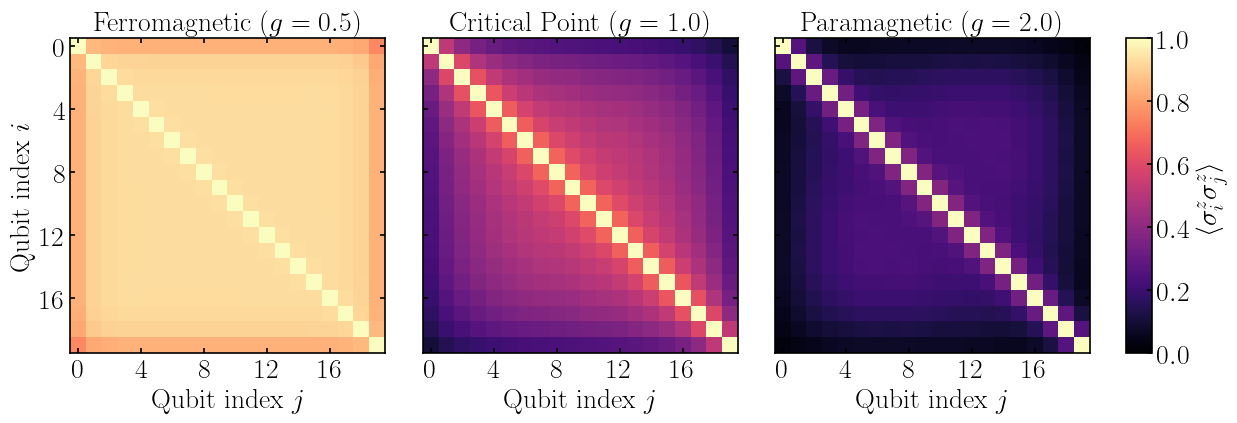

In [16]:
# Plot
fig, axes = plt.subplots(1, 3, figsize=(13, 4.5), sharey=True)

for idx, g in enumerate(g_vals):
    ax = axes[idx]
    mat = np.abs(matrices[g]) 
    
    # Heatmpa settings
    im = ax.imshow(mat, cmap="magma", origin="upper", aspect="equal", vmin=0, vmax=1)
    
    ax.set_title(f"{phase_names[g]} ($g={g}$)")
    ax.set_xlabel("Qubit index $j$")
    if idx == 0:
        ax.set_ylabel("Qubit index $i$")
        
    ax.set_xticks(np.arange(0, n_qubits, 4))
    ax.set_yticks(np.arange(0, n_qubits, 4))

plt.subplots_adjust(left=0.05, right=0.85, bottom=0.15, top=0.85, wspace=0.05)
cax = fig.add_axes([0.87, 0.15, 0.02, 0.7]) 
cbar = fig.colorbar(im, cax=cax)
cbar.set_label(r"$\langle \sigma_i^z \sigma_j^z \rangle$", rotation=90)

plt.savefig("plots/correlation2D.pdf", bbox_inches="tight")
plt.show()

### Von-Neumann entropy for bipartite systems $S_{N/2} = -\text{Tr}(\rho_A \ln \rho_A)$

In [17]:
# Define simulation parameters
gmax = 3.0
stride = 50 

# Variables to save results
g_axis_ent = []
entropy_mid = []
entropy_profiles = []

# File saving management
ENTROPY_FILENAME = f"datafiles/entropy_data_N{n_qubits}.pickle"
FORCE_RECOMPUTE = False 

# Try to load data from the file if it exists 
entropy_data = load_results(ENTROPY_FILENAME)

if entropy_data is None or FORCE_RECOMPUTE:
    message_checkpoints(0, f"Computing entropy data for N={n_qubits}...", True)
    
    # Init the chain
    ising_chain = TFIMChain(n_qubits=n_qubits, T=T, n_steps=n_steps)
    
    # Compute the entropy
    g_axis_ent, entropy_mid, entropy_profiles = ising_chain.entropy(gmax=gmax, m=m, stride=stride)
    
    # Save data
    data_to_save = {
        "g_axis_ent": g_axis_ent,
        "entropy_mid": entropy_mid,
        "entropy_profiles": entropy_profiles,
        "m_bond": m
    }
    save_results(data_to_save, ENTROPY_FILENAME)
    message_checkpoints(0, "\nData correctly saved!", True)

else:
    # If the file exists, unpack the loaded data
    message_checkpoints(0, f"Using loaded data from '{ENTROPY_FILENAME}'.", True)
    g_axis_ent = entropy_data["g_axis_ent"]
    entropy_mid = entropy_data["entropy_mid"]
    entropy_profiles = entropy_data["entropy_profiles"]

Data correctly loaded from 'datafiles/entropy_data_N20.pickle'


Using loaded data from 'datafiles/entropy_data_N20.pickle'.


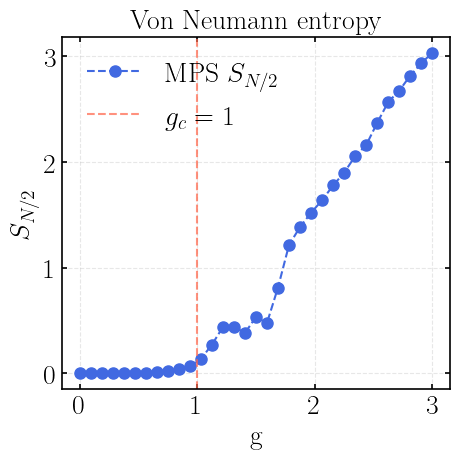

In [18]:
# Entropy plot
fig, ax = plt.subplots(figsize=(5, 5))

g_axis_ent = np.array(g_axis_ent)

# Linear fit
ax.plot(g_axis_ent, entropy_mid, "o--", color="royalblue", linewidth=1.5, label="MPS $S_{N/2}$")
ax.axvline(1.0, color="tomato", linestyle="dashed", alpha=0.7, label="$g_c=1$")
ax.set_xlabel("g")
ax.set_ylabel("$S_{N/2}$")
ax.set_title("Von Neumann entropy")
ax.legend(frameon=False)
ax.grid(True, linestyle="dashed", alpha=0.3)

plt.tight_layout()
plt.savefig("plots/entropy.pdf")
plt.show()